In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from math import factorial
from scipy.special import eval_genlaguerre
import matplotlib

In [2]:
# Jonah's conventions for the unit cell and stuff
q1 = -np.array([0.0,-1.0],dtype = complex)  # lattice vectors in the Q lattice
q2 = -np.array([np.sqrt(3)/2,0.5],dtype = complex)
q3 = -np.array([-np.sqrt(3)/2,0.5],dtype = complex)

b1 = q2 - q1
b2 = q3 - q1

# Lattice vectors
a1 = (2./3)*np.array([-np.sqrt(3)/2,-0.5],dtype = complex)  # lattice vectors in the Q lattice
a2 = (2./3)*np.array([np.sqrt(3)/2,-0.5],dtype = complex)  # lattice vectors in the Q lattice

# special points in the MBZ
kpt = -q3 # The K point
gpt = np.array([0.0,0.0], dtype = complex) # The Gamma point
mpt = -q3 - 0.5*q1 # The M point
mmpt = -mpt
kppt = -kpt

# 3 parameters  
w0 = 0.8/np.sqrt(3)
w1 = 1/np.sqrt(3)
vFkth = 110.0*np.sqrt(3)

In [3]:
ax1, ay1 = a1
ax2, ay2 = a2
omega = abs(ax1 * ay2 - ay1 * ax2)
    
z1 = (ax1 + 1.0j*ay1)/np.sqrt(omega)
z1bar = (ax1 - 1.0j*ay1)/np.sqrt(omega)
z2 = (ax2 + 1.0j*ay2)/np.sqrt(omega)
z2bar = (ax2 - 1.0j*ay2)/np.sqrt(omega)

In [4]:
def distance(a,b): # finds the distance between two complex vectors
    x0, y0 = np.real(a) # because they were complex, cast to real and then unpack to get x, y
    x1, y1 = np.real(b)
    return(np.sqrt((x0-x1)**2 + (y0 - y1)**2))

In [5]:
formFactors1 = np.load('TBG_Form_Factors_G1.npy')
formFactors2 = np.load('TBG_Form_Factors_G2.npy')

def calculateMatrixElement1(k,m,n):
    G1 = 1.
    G2 = 0. 
    k1 = 2*np.pi*np.dot(a1,k)
    k2 = 2*np.pi*np.dot(a2,k)
    return(np.exp(1.0j*(k1*G2-k2*G1)) * formFactors1[m][n])

def calculateMatrixElement2(k,m,n):
    G1 = 0.
    G2 = 1. 
    k1 = 2*np.pi*np.dot(a1,k)
    k2 = 2*np.pi*np.dot(a2,k)
    return(np.exp(1.0j*(k1*G2-k2*G1)) * formFactors2[m][n])

In [6]:
# First calculate the t-matrices, which do not change for different k-points, and kinetic terms

num_landau = 80
energy = np.sqrt((3*np.sqrt(3))/(2*np.pi))
kinetic_1 = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
kinetic_2 = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
t1_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
t2_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
t3_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)

# First we add the kinetic terms
for m in range(-num_landau,num_landau+1): 
    kinetic_1[m][m] = energy * np.sqrt(abs(m)) *np.sign(m)
    kinetic_2[m][m] = energy * np.sqrt(abs(m)) *np.sign(m)

# The second kinetic term is more complicated    
for m in range(-num_landau,num_landau+1):
    for n in range(-num_landau,num_landau+1):
        if (abs(m)-1 == abs(n)):
            coeff = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m))))
            kinetic_2[m][n] = 0.5j*np.sign(m)*coeff
            kinetic_1[m][n] = -0.5j*np.sign(m)*coeff
        elif (abs(m) == abs(n)-1):
            coeff = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m))))
            kinetic_2[m][n] = -0.5j*np.sign(n)*coeff
            kinetic_1[m][n] = 0.5j*np.sign(n)*coeff

# now the T-matrices, but the k-dependence is factored out
for m in range(-num_landau,num_landau+1):
    for n in range(-num_landau,num_landau+1):            
        coe = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m))))
            
        t2_matrix[m][n] += coe*w0*formFactors1[abs(m),abs(n)]
        t3_matrix[m][n] += coe*w0*formFactors2[abs(m),abs(n)]
            
        if abs(n) > 0 and abs(m) > 0:
            t2_matrix[m][n] += np.sign(m*n)*coe*w0*formFactors1[abs(m)-1,abs(n)-1]
            t3_matrix[m][n] += np.sign(m*n)*coe*w0*formFactors2[abs(m)-1,abs(n)-1]

        if abs(n) > 0:
            t2_matrix[m][n] += np.sign(n)*coe*w1*np.exp(-2.0j*np.pi/3)*formFactors1[abs(m),abs(n)-1]
            t3_matrix[m][n] += np.sign(n)*coe*w1*np.exp(2.0j*np.pi/3)*formFactors2[abs(m),abs(n)-1]

        if abs(m) > 0:
            t2_matrix[m][n] += np.sign(m)*coe*w1*np.exp(2.0j*np.pi/3)*formFactors1[abs(m)-1,abs(n)]
            t3_matrix[m][n] += np.sign(m)*coe*w1*np.exp(-2.0j*np.pi/3)*formFactors2[abs(m)-1,abs(n)]

        if abs(m) == abs(n):
            t1_matrix[m][n] += w0*coe
            if abs(m) != 0:
                t1_matrix[m][n] += w0*coe*np.sign(m*n)
                    
        if abs(m)-1 == abs(n) and abs(m) != 0:
            t1_matrix[m][n] += w1*coe*np.sign(m)
                
        if abs(n)-1 == abs(m) and abs(n) != 0:
            t1_matrix[m][n] += w1*coe*np.sign(n)

def generateHam(k):
    k1 = 2*np.pi*np.dot(a1,k)
    k2 = 2*np.pi*np.dot(a2,k)
    t_mat = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
    t_mat = t1_matrix + np.exp(-1.0j*k2) * t2_matrix + np.exp(1.0j*k1) *t3_matrix
    hamiltonian = np.block([[kinetic_1, t_mat.conj().T], [t_mat, kinetic_2]])
    return(vFkth*hamiltonian)

In [7]:
# generate path in MBZ to plot
numpoints = 50 # path divided into pieces.  There are 3*numpoints, from K to Gamma to M to K
g_to_k = [gpt * (1.0 - (t+0.0)/numpoints) + kpt * ((t+0.0)/numpoints) for t in range(numpoints)] # from K to Gamma
k_to_m = [kpt * (1.0 - (t+0.0)/numpoints) + mpt * ((t+0.0)/numpoints) for t in range(numpoints)] # from Gamma to M
m_to_g = [mpt * (1.0 - (t+0.0)/numpoints) + gpt * ((t+0.0)/numpoints) for t in range(numpoints)] # from M to K
g_to_mm = [gpt * (1.0 - (t+0.0)/numpoints) + mmpt * ((t+0.0)/numpoints) for t in range(numpoints)]
mm_to_kp = [mmpt * (1.0 - (t+0.0)/numpoints) + kppt * ((t+0.0)/numpoints) for t in range(numpoints)]

list_of_points = g_to_k+k_to_m+m_to_g+g_to_mm+mm_to_kp # + means append here, so the list is 3*numpoints long
array_of_points = np.array(list_of_points) # to numpy array

# some intervals between points are longer than others.  Fix by normalizing by length
len_k = [0.0] # this is the x-axis of the band structure plot.  starting at 0,
prev_k = 0.0
for i in range(len(list_of_points) - 1):
    prev_k += distance(array_of_points[i+1],array_of_points[i]) # add distances cumulatively
    len_k.append(prev_k)

In [8]:
listOfEigenvals = []  # will hold all the eigenvalues.  Probably would be faster with sparse matrices and Lanczos
for i, k_vec in enumerate(list_of_points):  # for each k-point in the path
    ham = generateHam(k_vec)  # build Hk
    eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues
    listOfEigenvals.append(eigenvals)  # add to list

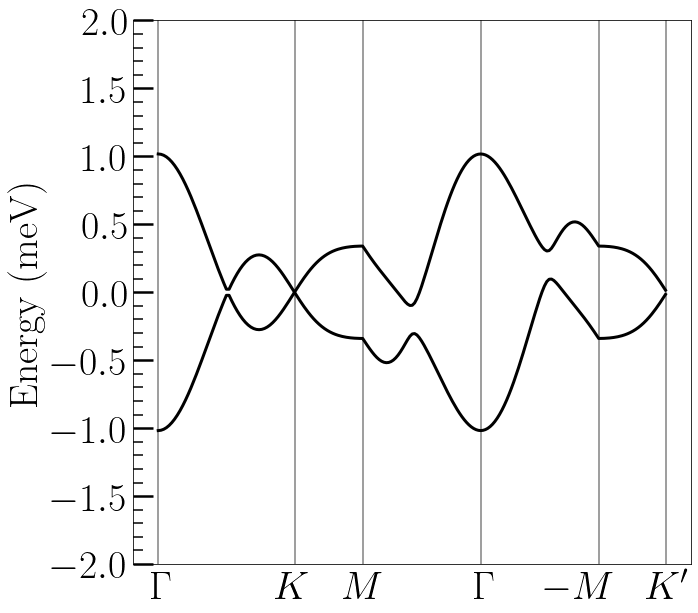

In [17]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import ticker

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 40}

matplotlib.rc('font', **font)
matplotlib.rc('text',usetex=True)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
plt.subplots_adjust(wspace=0.2)

axes.get_xaxis().set_visible(False)
axes.tick_params(direction="in",width=2.5, length=180)

arrayOfEigenvals=np.array(listOfEigenvals)# take the 8 bands closest to 0 energy
axes.axvline(x=len_k[0],color='gray')
axes.text(len_k[0]-.05,-2-0.25,r'$\Gamma$',rotation=0)
axes.axvline(x=len_k[50],color='gray')
axes.text(len_k[50]-.15,-2-0.25,r'$K$',rotation=0)
axes.axvline(x=len_k[100],color='gray')
axes.text(len_k[100]-.15,-2-0.25,r'$M$',rotation=0)
axes.axvline(x=len_k[150],color='gray')
axes.text(len_k[150]-.05,-2-0.25,r'$\Gamma$',rotation=0)
axes.axvline(x=len_k[200],color='gray')
axes.text(len_k[200]-.4,-2-0.25,r'$-M$',rotation=0)
axes.axvline(x=len_k[249],color='gray')
axes.text(len_k[249]-.15,-2-0.25,r"$K'$",rotation=0)
axes.set_ylim([-2, 2])

#axes[0].xlim([-0.075,len_k[249]+.075])
#plt.ylim([0,2*np.pi])

axes.set_ylabel(r'Energy (meV)')
for i in range(160,162):
    axes.plot(len_k, arrayOfEigenvals[:,i],linewidth=3,color='black')
    

axes.get_yaxis().set_major_locator(MultipleLocator(0.5))
axes.get_yaxis().set_minor_locator(MultipleLocator(0.1))
axes.tick_params(which='major',direction="in",width=2.5, length=20)
axes.tick_params(which='minor',direction="in",width=1.5, length=10)


axes.tick_params(direction="in",width=2.5, length=20)

plt.savefig('Phase_A_Zoomed.pdf',bbox_inches='tight')